In [1]:
import cv2
import datetime
import glob
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import pandas as pd
import os
import re
import shutil
import subprocess
import sys
import time

from skimage import io
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

srcfn = "/home/kiuchi/test_rugby_source.ts"
tgtfn = '/home/kiuchi/test_rugby_x265-01.mp4'
#tgtfn = '/home/kiuchi/test.mp4'
forcereload = False


In [2]:
if not os.path.exists(tgtfn+".log") or forcereload:
    cmdstr = ["/usr/bin/ffprobe", "-select_streams", "v", "-show_entries", "frame=pkt_size,pkt_pts_time", tgtfn]
    fh = open(tgtfn+".log", "w")
    p = subprocess.Popen(cmdstr, stdout=subprocess.PIPE)
    fh.write(p.communicate()[0].decode("utf-8", "ignore"))
    fh.close()
    os.sync()

infodict = []
with open(tgtfn+".log") as fh:
    for line in fh:
        line = line.rstrip()
        if re.match(r'pkt_pts_time=', line) != None:
            #print(line[re.match(r'pkt_pts_time=', line).end():])
            time = float(line[re.match(r'pkt_pts_time=', line).end():])
        if re.match(r'pkt_size=', line) != None:
            #print(line[re.match(r'pkt_size=', line).end():])
            size = float(line[re.match(r'pkt_size=', line).end():])
        if re.match(r'\[/FRAME\]', line) != None:
            #print("{0:10.03f}: {1:10.03f}".format(time, size))
            infodict.append({"time": time, "size": size})
df = pd.DataFrame(infodict)
df["sec"] = df["time"].astype(int)

In [3]:
dfb = df.groupby("sec").agg({"size": ['sum']}).reset_index()
dfb["Kbps"]=dfb[("size","sum")]*8/1024
dfb["10sec"]=dfb["sec"]/10
dfb["10sec"]=dfb["10sec"].astype(int)
dfc = dfb.groupby("10sec").agg({"Kbps": ['mean', 'min', 'max']})

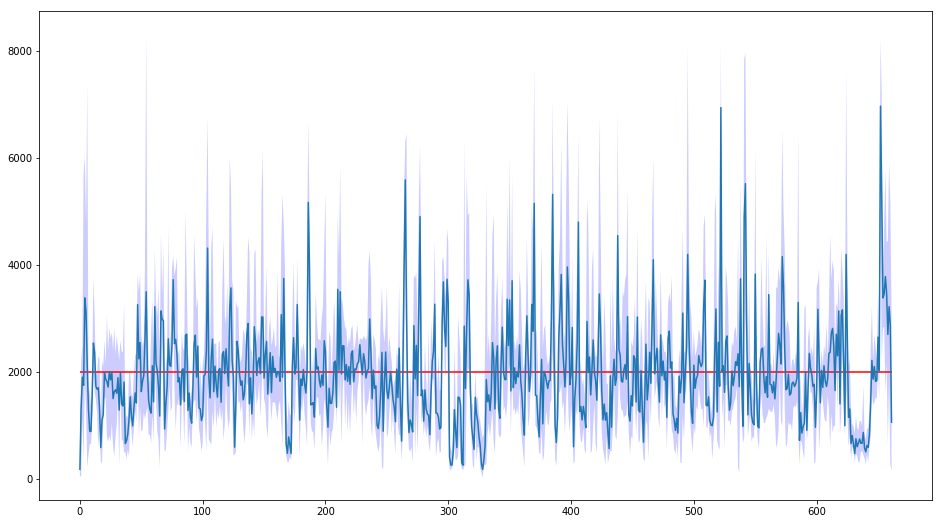

In [4]:
plt.figure(figsize=(16,9))
#dfc=dfc.sort_values(("Kbps", "mean")).reset_index()
#x = dfc.reset_index()["10sec"].values
x=list(range(len(dfc)))
plt.fill_between(x, dfc[("Kbps", "min")].values, dfc[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
plt.plot(dfc[("Kbps", "mean")].values)
plt.hlines(2000, x[0], x[-1], colors='red')
plt.show()

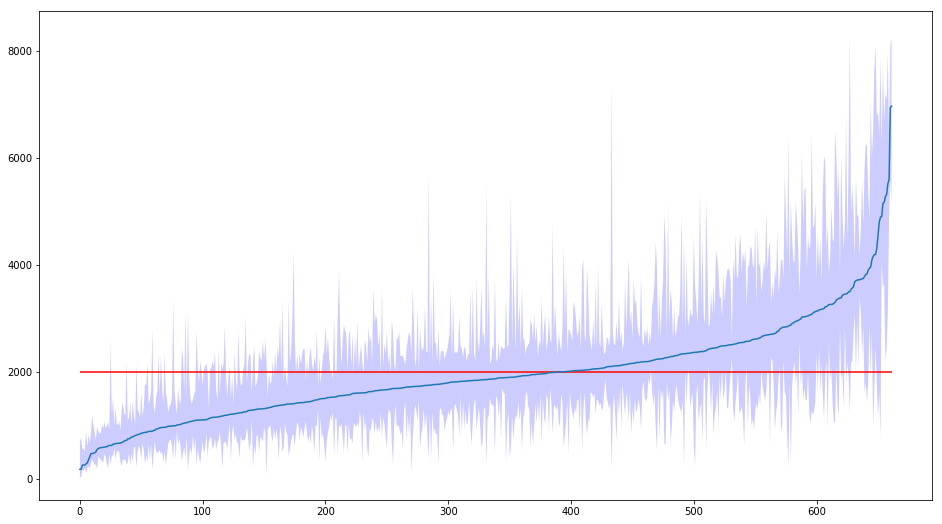

In [5]:
plt.figure(figsize=(16,9))
dfc=dfc.sort_values(("Kbps", "mean")).reset_index()
#x = dfc.reset_index()["10sec"].values
x=list(range(len(dfc)))
plt.fill_between(x, dfc[("Kbps", "min")].values, dfc[("Kbps", "max")].values, facecolor='blue', linewidth=0, alpha=0.2)
plt.plot(dfc[("Kbps", "mean")].values)
plt.hlines(2000, x[0], x[-1], colors='red')
plt.show()

In [6]:
df

,size,time,sec
0,84848.0,0.000000,0
1,106.0,0.033367,0
2,106.0,0.066733,0
3,106.0,0.100100,0
4,77.0,0.133467,0
5,262.0,0.166834,0
6,94.0,0.200200,0
7,94.0,0.233567,0
8,118.0,0.266934,0
9,99.0,0.300300,0


In [7]:
def generatePSNR(srcdir, tgtdir, nof):
    retar=[]
    for idx in range(nof):
        src = io.imread(srcdir+"/{:06d}.png".format(idx+1))
        tgt = io.imread(tgtdir+"/{:06d}.png".format(idx+1))
        psnrval = psnr(src, tgt, data_range=tgt.max()-tgt.min())
        #print(idx, psnrval)
        retar.append(psnrval)
    return retar
def extractImage(idx, srcdir, tgtdir, srcfn, tgtfn, timestr):
    if os.path.exists(srcdir):
        shutil.rmtree(srcdir)
    os.mkdir(srcdir)
    if os.path.exists(tgtdir):
        shutil.rmtree(tgtdir)
    os.mkdir(tgtdir)
    
    cmdline = ["/usr/bin/ffmpeg", "-ss", timestr, "-i", srcfn, "-t", "00:00:01", "-r:v", "29.97", "-f", "image2", srcdir+"/%06d.png"]
    subprocess.run(cmdline)
    cmdline = ["/usr/bin/ffmpeg", "-ss", timestr, "-i", tgtfn, "-t", "00:00:01", "-r:v", "29.97", "-f", "image2", tgtdir+"/%06d.png"]
    subprocess.run(cmdline)
    
    nof = glob.glob(srcdir+"/*.png")
    return {"idx": idx, "val": generatePSNR(srcdir, tgtdir, len(nof))}

In [9]:
psnrar=[]
#inputar=[]
#p = Pool(2)
starttime = datetime.datetime.now()
for idx in range(len(df)):
    # 比較する開始時刻をセット
    start = idx
    second = start%60
    minute = int((start-second)/60)%60
    hour = int((start-(minute*60)-second)/3600)
    startstr = "{0:02d}:{1:02d}:{2:02d}".format(hour, minute, second)
    
    #inputar.append([idx, str(idx)+"src", str(idx)+"tgt", srcfn, tgtfn, startstr])
    
    psnrar.append(
        extractImage(
            idx,
            str(idx)+"src",
            str(idx)+"tgt",
            srcfn,
            tgtfn,
            startstr
        )
    )
    
    eststr=""
    if idx>0:
        curtime = datetime.datetime.now()
        dur = curtime - starttime
        perf = dur/idx
        est = ((len(df)-idx)*perf).total_seconds()
        essecond = est%60
        esminute = int((est-essecond)/60)%60
        eshour = int((est-(esminute*60)-essecond)/3600)
        eststr = "{0:02d}:{1:02d}:{2:02d}".format(int(eshour), int(esminute), int(essecond))
    else:
        esstr = ""
    
    #print(startstr, psnrar)
    end = len(df)
    esecond = end%60
    eminute = int((end-esecond)/60)%60
    ehour = int((end-(eminute*60)-esecond)/3600)
    endstr = "{0:02d}:{1:02d}:{2:02d}".format(ehour, eminute, esecond)
    el = idx/len(df)*100
    sys.stdout.write("\r{0:s}/{1:s}({2:05.1f}%), est eot: {3:s}".format(startstr, endstr, el, eststr))
    
    if idx>5:
        break
#print(inputar)
#with Pool(2) as p:
#    results = p.starmap(extractImage, inputar)
#    print(results)

00:00:06/55:06:28(000.0%), est eot: 635:49:45